In [26]:
import os
import shap

import plotly.io as pio
import numpy as np
import shap
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import display
import torch.nn as nn
from omnixai.data.image import Image
from omnixai.explainers.vision import L2XImage

import util
from model import MultiLogisticRegressionModel

In [27]:
def custom_cross_entropy_loss(input, target):
    target = target.long()
    return nn.CrossEntropyLoss()(input, target)

def multi_logistic_predict_function(images):
    """
    images: a list (or array) of omnixai.data.image.Image
    returns: a numpy array of shape [N, 10], each row is a softmax probability distribution
    """
    preds = []
    for im in images:
        # Convert image to numpy array with shape (28, 28)
        x_2d = im.to_numpy().astype(float)
        probs = model.hypothesis(x_2d)
        preds.append(probs)
    return np.array(preds)

def predict(flat_imgs):
    imgs = flat_imgs.reshape(-1, 28, 28)
    return np.array([model.hypothesis(img) for img in imgs])

def load_gray(path):
    return np.array(PILImage.open(path).convert('L')).astype(float) / 255.0

train_data = util.get_dataset("mnist_train")
test_data = util.get_dataset("mnist_test")

train_arrays = np.array(train_data.xs)
test_arrays = np.array(test_data.xs)

train_labels = np.array(train_data.ys, dtype=np.int64)
test_labels = np.array(test_data.ys, dtype=np.int64)

train_imgs = Image(train_arrays, batched=True)
test_imgs = Image(test_arrays, batched=True)

X_train_flat = train_arrays.reshape(-1, 28*28)
bg = X_train_flat[np.random.choice(len(X_train_flat), 100, replace=False)]
masker = shap.maskers.Independent(bg)

num_features = 28 * 28
num_classes = 10
learning_rate = 1e-2

model = MultiLogisticRegressionModel(
    num_features=num_features,
    num_classes=num_classes,
    learning_rate=learning_rate
)

In [28]:
model.train(train_data, evalset=test_data)

l2x_explainer = L2XImage(
    training_data=train_imgs,
    predict_function=multi_logistic_predict_function,
    loss_function=custom_cross_entropy_loss
)

shap_explainer = shap.Explainer(predict, masker)

 |████████████████████████████████████████| 100.0% Complete, Loss 0.3915
L2X prediction model accuracy: 0.9154666666666667


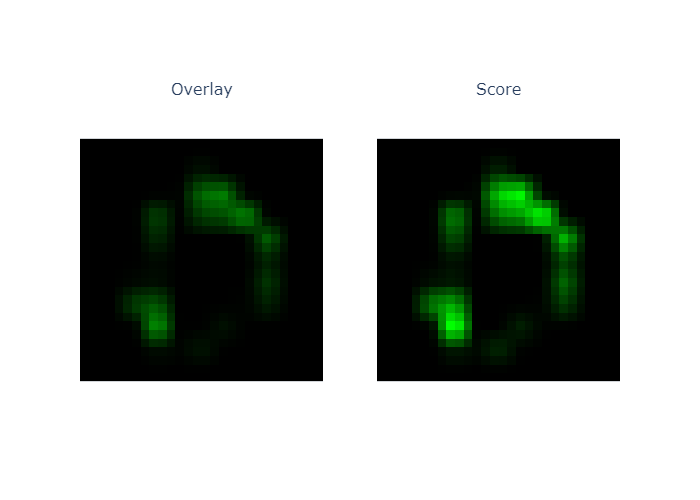

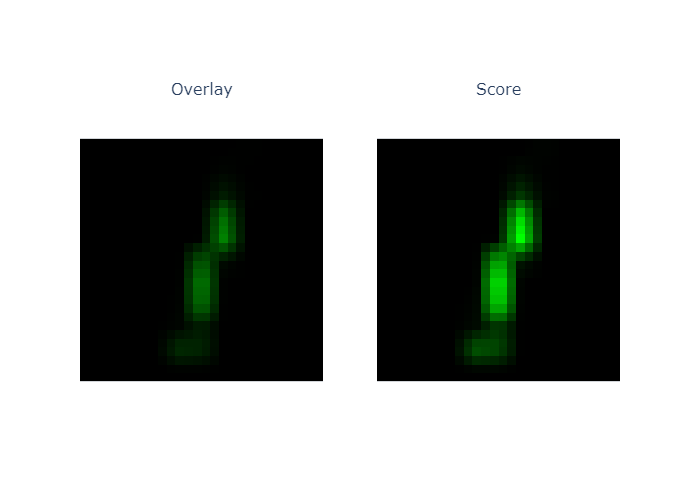

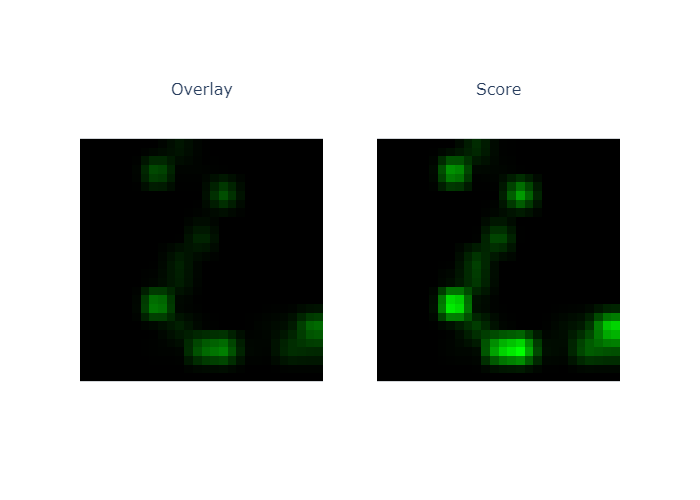

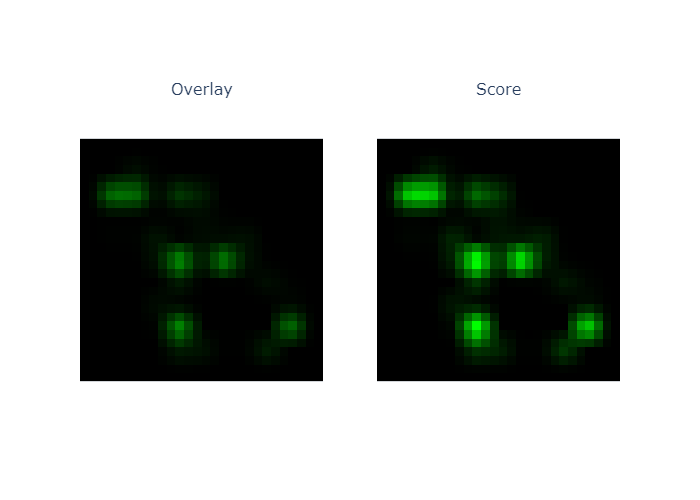

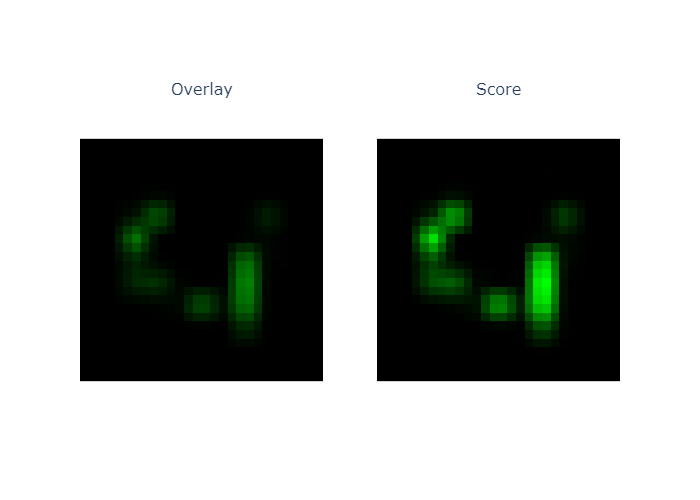

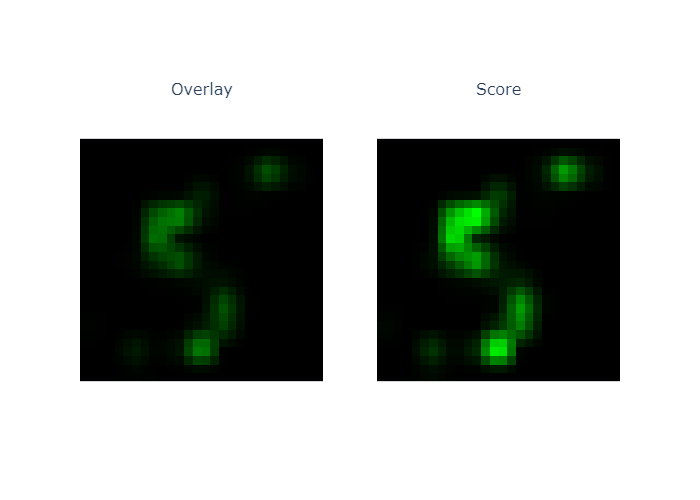

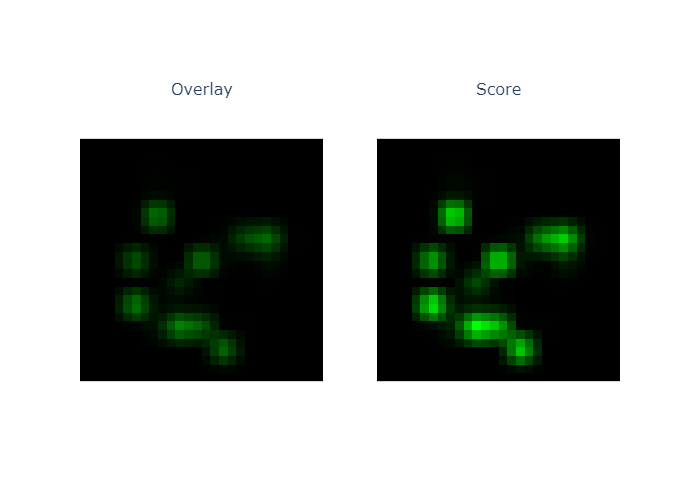

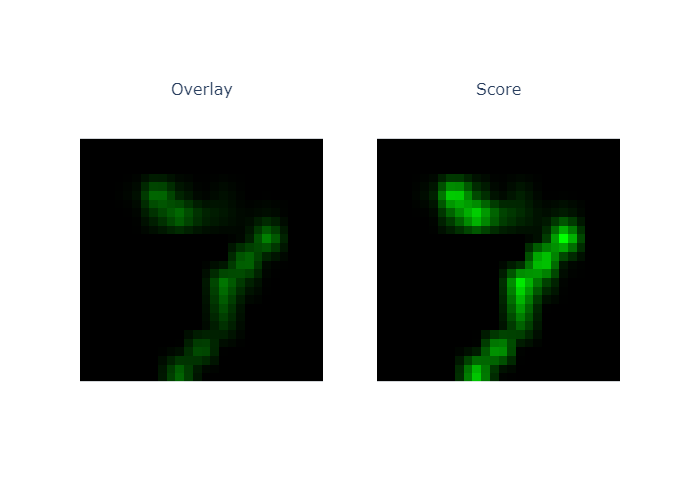

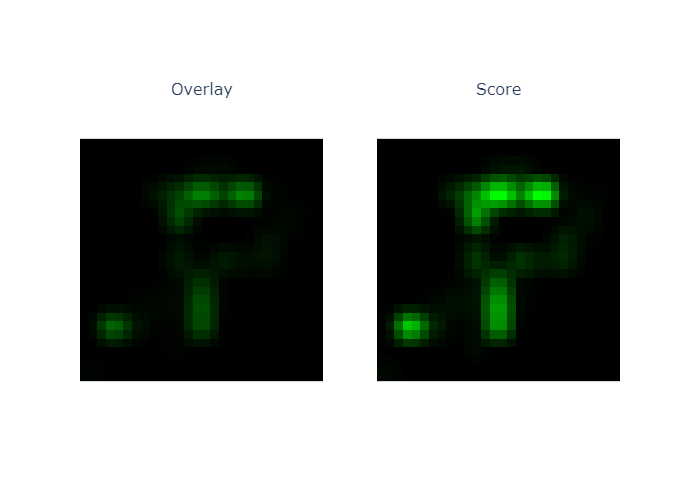

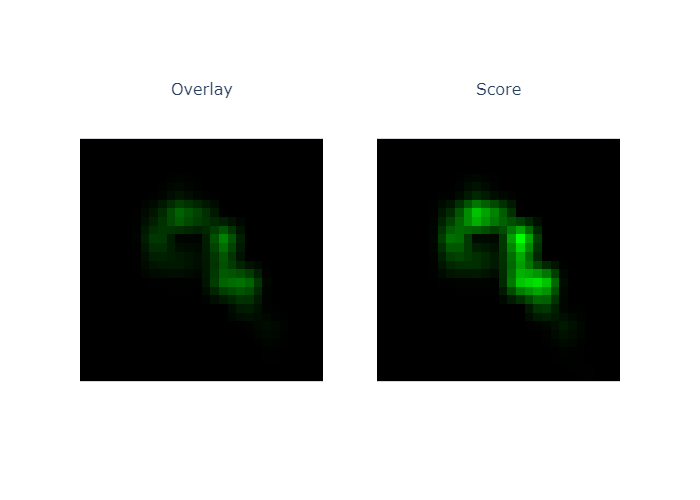

Predicted probabilities for the custom images:
 [[9.93234795e-01 2.26793180e-08 2.38047074e-04 2.58476921e-04
  4.37477033e-07 1.39071552e-03 3.56307319e-03 9.70971811e-04
  1.08121677e-04 2.35338452e-04]
 [2.29246683e-04 9.35541996e-01 2.08713529e-02 9.17625845e-03
  1.05064716e-03 3.87817435e-03 7.87686003e-03 8.25969150e-03
  1.03675425e-02 2.74823075e-03]
 [5.48958021e-03 5.51310436e-05 8.48830612e-01 1.67854074e-02
  2.32029669e-07 3.31791501e-02 8.99223603e-02 2.05507686e-07
  5.73241216e-03 4.90912345e-06]
 [4.40563787e-04 1.16243696e-03 5.38873075e-02 7.54362608e-01
  4.31172593e-03 4.92810602e-02 6.03576429e-02 2.28630676e-03
  6.69879901e-02 6.92235773e-03]
 [3.38763854e-03 4.27175303e-05 5.88813671e-03 1.41925247e-03
  7.80030594e-01 1.26431774e-03 9.86448521e-03 2.53810243e-02
  3.17630357e-02 1.40958797e-01]
 [7.60210848e-04 4.23493089e-05 2.43450391e-05 2.44953199e-04
  1.22229553e-02 9.55343763e-01 1.78391997e-02 2.05427923e-05
  7.67961566e-03 5.82206468e-03]
 [1.176049

In [57]:
explained_imgs_list = []
for i in range(10):
    file_path = os.path.join("mnist_png", "explained_imgs", f"{i}.png")
    img = PILImage.open(file_path).convert('L')
    img_array = np.array(img).astype(float) / 255.0
    explained_imgs_list.append(img_array)

explained_imgs = Image(np.array(explained_imgs_list), batched=True)
explanations = l2x_explainer.explain(explained_imgs)

pio.renderers.default = "png"

for idx in range(len(explained_imgs)):
    fig = explanations._plotly_figure(index=idx, show_pred=True)
    fig.show() 
predictions = multi_logistic_predict_function(explained_imgs)
print("Predicted probabilities for the custom images:\n", predictions)

PermutationExplainer explainer: 11it [00:30,  4.31s/it]                        


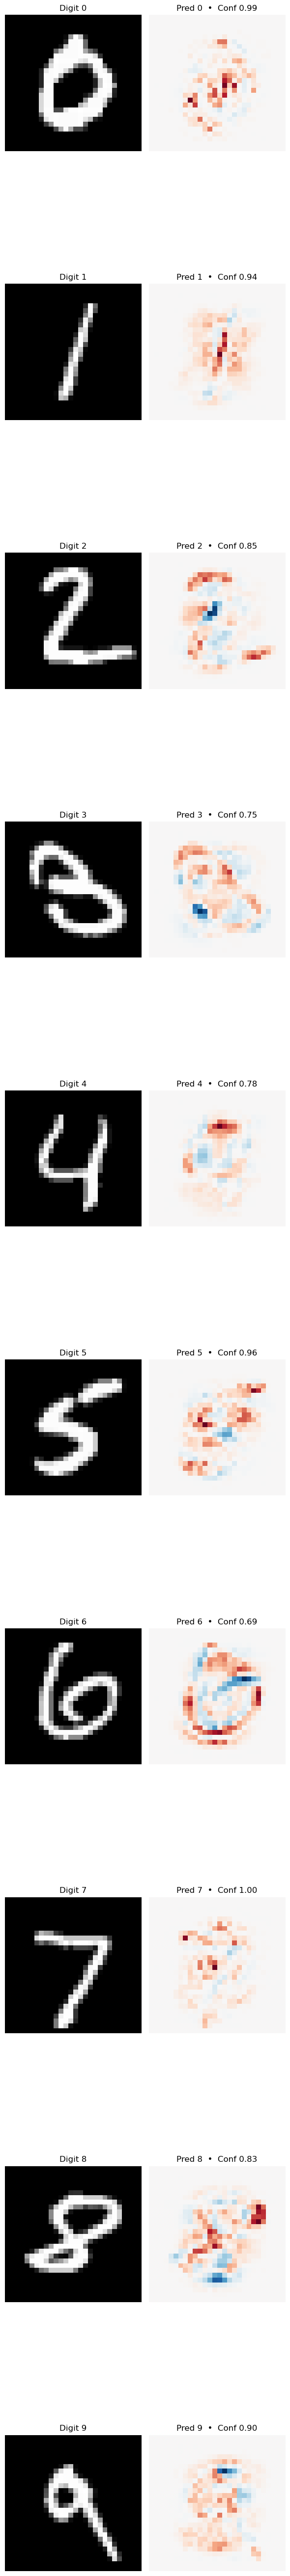

In [ ]:
%matplotlib inline

imgs = np.stack([
    load_gray(os.path.join("mnist_png", "explained_imgs", f"{i}.png"))
    for i in range(10)
])    

flat_imgs = imgs.reshape(10, -1)
exp      = shap_explainer(flat_imgs, max_evals=2000)
probs    = predict(flat_imgs)
pred_cls = np.argmax(probs, axis=1)

fig, ax = plt.subplots(10, 2, figsize=(6, 55))
fig.subplots_adjust(hspace=1.0)

for i in range(10):
    shap_map = exp.values[i, :, pred_cls[i]].reshape(28, 28)
    vmax = np.max(np.abs(shap_map))
    vmin = -vmax

    # left: original digit
    ax[i, 0].imshow(imgs[i], cmap='gray')
    ax[i, 0].set_title(f"Digit {i}", fontsize=12)
    ax[i, 0].axis("off")

    # right: shap map
    ax[i, 1].imshow(shap_map, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax[i, 1].set_title(
        f"Pred {pred_cls[i]}  •  Conf {probs[i, pred_cls[i]]:.2f}",
        fontsize=12
    )
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()
